# 100 Sports Image Classification

Source: [Link to Kaggle](https://www.kaggle.com/datasets/gpiosenka/sports-classification)

## About Dataset



> Collection of sports images covering 100 different sports.. Images are 224,224,3 jpg format. Data is separated into train, test and valid directories. 



In [1]:
!pip install pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-tjw592xs/pytorch_c34afd1475494a3ab34181f35e04880e/setup.py'"'"'; __file__='"'"'/tmp/pip-install-tjw592xs/pytorch_c34afd1475494a3ab34181f35e04880e/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-is_bah9e/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.8/pytorch Check the logs f

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas 
import json
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

import os
import time

%matplotlib inline 

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [6]:
!unzip /content/drive/MyDrive/DataSets/SportsImageRecognition/sports_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/rings/058.jpg     
  inflating: train/rings/059.jpg     
  inflating: train/rings/060.jpg     
  inflating: train/rings/061.jpg     
  inflating: train/rings/062.jpg     
  inflating: train/rings/063.jpg     
  inflating: train/rings/064.jpg     
  inflating: train/rings/065.jpg     
  inflating: train/rings/066.jpg     
  inflating: train/rings/067.jpg     
  inflating: train/rings/068.jpg     
  inflating: train/rings/069.jpg     
  inflating: train/rings/070.jpg     
  inflating: train/rings/071.jpg     
  inflating: train/rings/072.jpg     
  inflating: train/rings/073.jpg     
  inflating: train/rings/074.jpg     
  inflating: train/rings/075.jpg     
  inflating: train/rings/076.jpg     
  inflating: train/rings/077.jpg     
  inflating: train/rings/078.jpg     
  inflating: train/rings/079.jpg     
  inflating: train/rings/080.jpg     
  inflating: train/rings/081.jpg     
  inflating: train/rings/082.jpg     

In [6]:
!ls

 class_dict.csv   EfficientNetB3-sports-0.97.h5   sample_data   test    valid
 drive		 'images to predict'		  sports.csv    train




> Defining batch size



In [2]:
batch_size = 18

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
}

In [4]:
def get_dataset(transforms, curr_dir = os.path.abspath(os.curdir)):
    image_datasets = { x: datasets.ImageFolder(os.path.join(curr_dir, x),
                                              transforms[x])
                      for x in ['train', 'valid', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=2)
                      for x in ['train', 'valid', 'test']  
    }

    datasets_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, class_names, datasets_sizes

In [7]:
dataloaders, class_names, datasets_sizes = get_dataset(transforms=data_transforms)

In [8]:
print('Datasets sizes: {}'.format(datasets_sizes))
print('Num_of_classes: {}, Classes: {}'.format(len(class_names), class_names))

Datasets sizes: {'train': 13572, 'valid': 500, 'test': 500}
Num_of_classes: 100, Classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing'

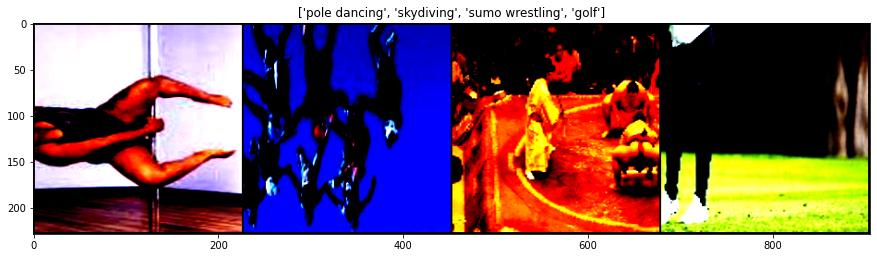

In [18]:
def imshow_before_normalization(input, title = None):
    input = input.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15, 4))
    plt.imshow(input)
    
    if title is not None:
        plt.title(title)

inputs, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:int(np.sqrt(batch_size))])
imshow_before_normalization(out, title=[class_names[x] for x in labels[:int(np.sqrt(batch_size))]])



> Finding parameters for normalization



In [10]:
def get_statistics(dataloaders):
    mean, std = torch.zeros(3), torch.zeros(3)
    count_img = 0
    for inputs, _ in dataloaders['train']:
        for i in range(inputs.shape[0]):
            mean += inputs[i].mean([1, 2])
            std += inputs[i].std([1, 2])
        count_img += inputs.shape[0]
    mean, std = mean / count_img, std / count_img
    return mean.tolist(), std.tolist()

mean, std = get_statistics(dataloaders)

print('Mean: {}'.format(mean))
print('Std: {}'.format(std))

Mean: [0.4714464247226715, 0.4700109362602234, 0.4550049901008606]
Std: [0.24042482674121857, 0.2305058091878891, 0.23282687366008759]




> Changing transforms and getting normalized dataset



In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [13]:
dataloaders, class_names, datasets_sizes = get_dataset(transforms=data_transforms)



> Normalized images

In [20]:
def imshow_after_normalization(input, title=None):

    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)

    plt.figure(figsize=(15, 4))
    plt.imshow(input)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

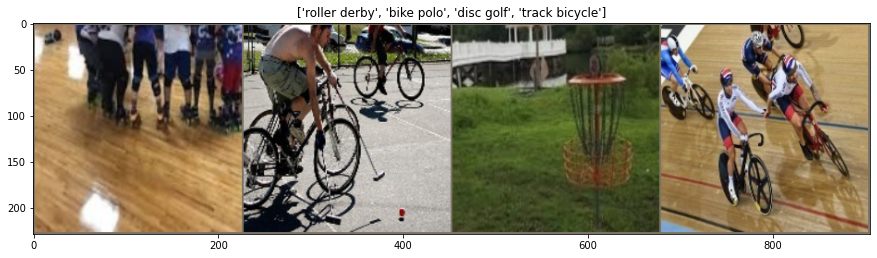

In [21]:
inputs, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:int(np.sqrt(batch_size))])
imshow_after_normalization(out, title=[class_names[x] for x in labels[:int(np.sqrt(batch_size))]])

## Training the model

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
def train_the_model(net, optimizer, loss, scheduler, num_epochs):
    start_time = time.time()
    
    losses = {'train': [],
            'valid': []}

    accuracies = {'train': [],
                'valid': []}
    best_accuracy = 0.0 
    best_net_params = net.state_dict()     

    for epoch in range(num_epochs):

        for phase in ['train', 'valid']:

            if phase == 'train':
                net = net.train(True)
                scheduler.step()
            else:
                net = net.eval()
            
            curr_losses = 0.0
            curr_corrects = 0

            for batch, labels in dataloaders[phase]:
              
                batch = batch.to(device)
                labels = labels.to(device)

                if phase == 'train':
                    optimizer.zero_grad()
                
                # forward pass
                if phase == 'valid': 
                    with torch.no_grad():
                        outputs = net(batch)
                else:
                    outputs = net(batch)
                preds = torch.argmax(outputs, -1)
                loss_ = loss(outputs, labels)

                # backward pass
                if phase == 'train':
                    loss_.backward()
                    optimizer.step()
                
                # statistics
                curr_losses += loss_.item()
                curr_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = curr_losses / datasets_sizes[phase]
            epoch_accuracy = curr_corrects / datasets_sizes[phase]

            print('{} phase: Loss: {:.3f} Acc: {:.3f}'.format(phase, 
                                                      epoch_loss,
                                                      epoch_accuracy))
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)

            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_net_params = net.state_dict()


    # results
    training_time = time.time() - start_time

    print('Time complete: {:.0f}m {:.0f}s'.format(training_time // 60,
                                                  training_time % 60))
    print('Best Acc: {:.4f}'.format(best_accuracy))

    net.load_state_dict(best_net_params)
    return net, losses, accuracies, best_accuracy





> Evaluating model's quality on test dataset



In [23]:
def evaluate_on_test(net):

    curr_corrects = 0
    test_labels = []
    net.eval()

    with torch.no_grad():
        for batch, labels in dataloaders['test']:

            batch = batch.to(device)
            labels = labels.to(device)

            outputs = net(batch)
            _, preds = torch.max(outputs, 1)
            # labels = torch.argmax(outputs, -1)

            curr_corrects += int(torch.sum(preds == labels.data))
            test_labels.append(preds)

    return curr_corrects / datasets_sizes['test'], test_labels




> For saving future results of different models



In [24]:
def to_save(model, path):
  
    torch.save(model.state_dict(), path)

In [25]:
def to_load(model, path):
  
    model.load_state_dict(torch.load(path))
    model.eval()

In [26]:
def to_json(dict, path):
  
    with open(path, 'w') as js_file:
        json.dump(dict, js_file)

In [27]:
def json_to_dict(path):
  
    with open(path, 'r') as js_file:
        dict_ = json.load(js_file)
    return dict_

## Defining hyperparameters

In [29]:
# Net needed parameters
lr = 1.0e-3
num_epochs = 25
# Criterion
loss = loss = nn.CrossEntropyLoss()


# for saving 
PATH = '/content/drive/MyDrive/DataSets/SportsImageRecognition/'
results = {}
json_file_name = 'models_results'

## ResNet18

In [30]:
class ResNet18_():

    def __init__(self, fine_tuning = True):
        self.fine_tuning = fine_tuning
        self.model = self.__build_model__()

    def __build_model__(self):
        model = models.resnet18(pretrained=True)

        if self.fine_tuning is not True:
            for param in model.parameters():
                param.requires_grad = False

        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 100)

        return model



### FineTuning approach

In [31]:
resnet_ft = ResNet18_().model
resnet_ft = resnet_ft.to(device)

# Optimizer
# lr-decay
optimizer = optim.Adam(resnet_ft.parameters(), lr=lr)
lr_scheduler_ = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
# training model
resnet_ft_trained, losses, accuracies, best_acc = train_the_model(resnet_ft,
                                                        optimizer,
                                                        loss,
                                                        lr_scheduler_,
                                                        num_epochs = num_epochs )

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train phase: Loss: 0.187 Acc: 0.190
valid phase: Loss: 0.115 Acc: 0.448
train phase: Loss: 0.132 Acc: 0.380
valid phase: Loss: 0.074 Acc: 0.614
train phase: Loss: 0.109 Acc: 0.476
valid phase: Loss: 0.061 Acc: 0.696
train phase: Loss: 0.097 Acc: 0.531
valid phase: Loss: 0.053 Acc: 0.740
train phase: Loss: 0.088 Acc: 0.571
valid phase: Loss: 0.045 Acc: 0.768
train phase: Loss: 0.081 Acc: 0.597
valid phase: Loss: 0.042 Acc: 0.774
train phase: Loss: 0.057 Acc: 0.720
valid phase: Loss: 0.022 Acc: 0.882
train phase: Loss: 0.050 Acc: 0.755
valid phase: Loss: 0.020 Acc: 0.894
train phase: Loss: 0.048 Acc: 0.763
valid phase: Loss: 0.019 Acc: 0.902
train phase: Loss: 0.045 Acc: 0.775
valid phase: Loss: 0.019 Acc: 0.902
train phase: Loss: 0.042 Acc: 0.790
valid phase: Loss: 0.018 Acc: 0.912
train phase: Loss: 0.041 Acc: 0.795
valid phase: Loss: 0.017 Acc: 0.914
train phase: Loss: 0.040 Acc: 0.800
valid phase: Loss: 0.018 Acc: 0.910
train phase: Loss: 0.037 Acc: 0.819
valid phase: Loss: 0.017 Acc



> Saving parameters:



In [32]:
file_name = 'Resnet18_FT_trained.pt'

In [35]:
to_save(resnet_ft_trained, PATH + file_name)



> Trained model loading



In [35]:
# Model initialization
resnet_ft = ResNet18_().model

# Load
to_load(resnet_ft, PATH + file_name)

resnet_ft = resnet_ft.to(device)

RuntimeError: ignored



> Model evaluation on test dataset



In [37]:
best_acc_test, preds_on_test = evaluate_on_test(resnet_ft)

In [38]:
results['resnet18_ft'] = {
                          'name': 'ResNet18 + FineTuning',
                          'loss_history': losses,
                          'acc_history': accuracies,
                          'best_acc_val': best_acc,
                          'best_acc_test': best_acc_test,
                          'preds_on_test': preds_on_test,
                          'date': datetime.datetime.now()
                          }

### FeatureEctractor approach

In [39]:
resnet_fe = ResNet18_(fine_tuning=False).model
resnet_fe = resnet_fe.to(device)

# Optimizer
# lr-decay
optimizer = optim.Adam(resnet_fe.parameters(), lr=lr)
lr_scheduler_ = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# training model
resnet_fe_trained, losses, accuracies, best_acc = train_the_model(resnet_fe,
                                                        optimizer,
                                                        loss,
                                                        lr_scheduler_,
                                                        num_epochs = num_epochs)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train phase: Loss: 0.140 Acc: 0.442
valid phase: Loss: 0.049 Acc: 0.784
train phase: Loss: 0.075 Acc: 0.657
valid phase: Loss: 0.032 Acc: 0.850
train phase: Loss: 0.063 Acc: 0.700
valid phase: Loss: 0.028 Acc: 0.842
train phase: Loss: 0.058 Acc: 0.721
valid phase: Loss: 0.024 Acc: 0.876
train phase: Loss: 0.053 Acc: 0.739
valid phase: Loss: 0.023 Acc: 0.892
train phase: Loss: 0.052 Acc: 0.741
valid phase: Loss: 0.023 Acc: 0.890
train phase: Loss: 0.043 Acc: 0.790
valid phase: Loss: 0.018 Acc: 0.896
train phase: Loss: 0.043 Acc: 0.786
valid phase: Loss: 0.017 Acc: 0.904
train phase: Loss: 0.043 Acc: 0.794
valid phase: Loss: 0.018 Acc: 0.896
train phase: Loss: 0.043 Acc: 0.788
valid phase: Loss: 0.017 Acc: 0.898
train phase: Loss: 0.043 Acc: 0.790
valid phase: Loss: 0.017 Acc: 0.894
train phase: Loss: 0.043 Acc: 0.794
valid phase: Loss: 0.018 Acc: 0.894
train phase: Loss: 0.042 Acc: 0.795
valid phase: Loss: 0.017 Acc: 0.898
train phase: Loss: 0.042 Acc: 0.797
valid phase: Loss: 0.017 Acc



> Saving the model's parameters



In [41]:
file_name = 'ResNet18_FE_trained.pt'

In [42]:
to_save(model=resnet_fe_trained, path = PATH + file_name)



> Trained model loading



In [43]:
# Model initialization
resnet_fe = ResNet18_(fine_tuning=False).model

# Load
to_load(model=resnet_fe, path=PATH + file_name)

resnet_fe = resnet_fe.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)




> Model evaluation on test dataset



In [44]:
best_acc_test, preds_on_test = evaluate_on_test(resnet_fe)

In [45]:
results['resnet18_fe'] = {
                          'name': 'ResNet18 as FeatureExtractor',
                          'loss_history': losses,
                          'acc_history': accuracies,
                          'best_acc_val': best_acc,
                          'best_acc_test': best_acc_test,
                          'preds_on_test': preds_on_test,
                          'date': datetime.datetime.now()
                          }

## EfficientNetB2 + FineTuning

In [46]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d8220554b241c2a09534fba04cd83eb16808555d01a659de6c05046fc1847bc6
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [47]:
from efficientnet_pytorch import EfficientNet

In [53]:
class EfficientNetB2():
    def __init__(self, fine_tuning = True):
        self.fine_tuning = fine_tuning
        self.model = self.__build_model__()
    
    def __build_model__(self):
        model = EfficientNet.from_pretrained('efficientnet-b2')

        if self.fine_tuning is not True:
            for param in model.parameters():
                param.requires_grad = False

        in_features = model._fc.in_features
      
        model._fc = nn.Sequential(
            nn.BatchNorm1d(num_features=in_features),    
            nn.Linear(in_features, 704),
            nn.ReLU(),
            nn.BatchNorm1d(704),
            nn.Dropout(0.4),
            nn.Linear(704, 100),
            )  

        return model

In [54]:
eff_net = EfficientNetB2().model

eff_net = eff_net.to(device)

# Optimizer
# lr-decay
optimizer = optim.Adam(eff_net.parameters(), lr=lr)
lr_scheduler_ = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b2


In [ ]:
# training model
eff_net_trained, losses, accuracies, best_acc = train_the_model(eff_net,
                                                        optimizer,
                                                        loss,
                                                        lr_scheduler_,
                                                        num_epochs = num_epochs)

train phase: Loss: 0.128 Acc: 0.422
valid phase: Loss: 0.052 Acc: 0.726
train phase: Loss: 0.091 Acc: 0.576
valid phase: Loss: 0.044 Acc: 0.800
train phase: Loss: 0.078 Acc: 0.630
valid phase: Loss: 0.047 Acc: 0.770
train phase: Loss: 0.072 Acc: 0.655
valid phase: Loss: 0.026 Acc: 0.870
train phase: Loss: 0.065 Acc: 0.692
valid phase: Loss: 0.030 Acc: 0.856
train phase: Loss: 0.063 Acc: 0.698
valid phase: Loss: 0.032 Acc: 0.844
train phase: Loss: 0.045 Acc: 0.778
valid phase: Loss: 0.010 Acc: 0.946
train phase: Loss: 0.035 Acc: 0.825
valid phase: Loss: 0.008 Acc: 0.958
train phase: Loss: 0.032 Acc: 0.840
valid phase: Loss: 0.008 Acc: 0.968


In [ ]:
file_name = 'EfficientNetB2_FT_trained.pt'

In [ ]:
to_save(eff_net_trained, PATH + file_name)

In [ ]:
eff_net = EfficientNetB2()

to_load(eff_net, PATH + file_name)

eff_net = eff_net.to(device)



> Model evaluation on test dataset


In [ ]:
best_acc_test, preds_on_test = evaluate_on_test(eff_net)

In [ ]:
results['eff_net'] = {
                      'name': 'EfficientNetB2 + FineTuning',
                      'loss_history': losses,
                      'acc_history': accuracies,
                      'best_acc_val': best_acc,
                      'best_acc_test': best_acc_test,
                      'preds_on_test': preds_on_test,
                      'date': datetime.datetime.now()
                      }

In [ ]:
# writing results of training to json file
to_json(results, PATH + json_file_name)

## Visualization 

In [ ]:
# reading from json file
results = json_to_dict(PATH + json_file_name)

In [ ]:
sns.set(style="whitegrid", font_scale=1.4)

In [ ]:
def plot_figure1(data):

    fig = plt.figure(figsize=(15, 8))
    fig.title("Figure1. Results of different models training")

    for i, model in enumerate(results.keys()):

        name = data[model]['name']
        losses = data[model]['loss_history']
        metrics = data[model]['acc_history']
        best_acc_val = data[model]['best_acc_val']
        best_acc_test = data[model]['best_acc_test']

        ax = plt.subplot(1, 3, i)

        ax.plot(losses['train'], label = 'loss_train', color = 'orange')
        ax.plot(losses['valid'], label = 'loss_valid', color = 'purple')

        ax.plot(metrics['train'], label = 'accuracy_train', color = 'blue')
        ax.plot(metrics['valid'], label = 'accuracy_valid', color = 'red')

        ax.set_title('Model: {}'.format(name) + 
                    'Best Accuracy on valid: {}'.format(best_acc_val) +
                    'Best Accuracy on test: {}'.format(best_acc_test))
        ax.legend()
        ax.xlabel('Epoches')

    plt.show()    



In [ ]:
def plot_figure2_2(data):

    fig = plt.figure(figsize=(15, 8))
    fig.title("Figure2. Comparison of models by metrics")
    colors = ['purple', 'orange', 'blue']

    # Loss
    ax0 = plt.subplots(1, 2, 1)

    for model, color in zip(data.keys(), colors):
        name = data[model]['name']
        loss_val = data[model]['loss_history']['valid']

        ax0.plot(loss_val, color = color, label = name)
        ax0.set_title('Loss')
        ax0.legend()
        ax0.xlabel('Epoches')
        
    # Accuracy
    ax0 = plt.subplots(1, 2, 2)

    for model, color in zip(data.keys(), colors):
        name = data[model]['name']
        loss_val = data[model]['acc_history']['valid']

        ax0.plot(loss_val, color = color, label = name)
        ax0.set_title('Accuracy')
        ax0.legend()
        ax0.xlabel('Epoches')

    plt.show()  

In [ ]:
def plot_figure2(data):

    fig = plt.figure(figsize=(15, 8))
    fig.title("Figure2. Comparison of models by metrics")

    colors = ['purple', 'orange', 'blue']
    types = ['loss', 'acc']

    for i, type_ in zip(range(1, 3), types):
        ax = plt.subplots(1, 2, i)

        for model, color in zip(data.keys(), colors):
            name = data[model]['name']             
            values = data[model][type_ + '_history']['valid']

            ax.plot(values, color = color, label = name)

            if type_ == 'loss':
                ax.set_title('Loss')
            else:
                ax.set_title('Accuracy')

            ax.legend()
            ax.xlabel('Epoches')

    plt.show()

In [ ]:
def visualize_model_predictions(model,
                                class_names,
                                type_of_dataset = 'test',
                                num_images=4):

    model.eval()

    fig = plt.figure(figsize=(15, 4))
    
    with torch.no_grad():
        for inputs, labels in enumerate(dataloaders[type_of_dataset]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i,j in zip(range(1, num_images + 1), range(inputs.size()[0])):

                ax = plt.subplot(1, 2, i)
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
                imshow_after_normalization(inputs.cpu().data[j])
    

In [ ]:
plot_figure1(data = results)
plot_figure2(data = results)
visualize_model_predictions(resnet_ft, class_names, type_of_dataset = 'test')